In [1]:
# E-Commerce User Behavior Analysis Project

In [2]:
# Install the necessary library
!pip install google-cloud-bigquery[pandas]

# Authenticate to access your BigQuery project
from google.colab import auth
auth.authenticate_user()

# Set up project ID
project_id = 'second-pier-471114-b1'
print(f"Project ID set to: {project_id}")

Project ID set to: second-pier-471114-b1


In [6]:
# Import essential libraries
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt

# Set up the BigQuery client
client = bigquery.Client(project=project_id)

In [4]:
# Write a SQL query to get CLEAN data
sql = """
SELECT
  InvoiceNo,
  StockCode,
  Description,
  Quantity,
  InvoiceDate,
  UnitPrice,
  CustomerID,
  Country
FROM
  `{}.ecommerce.ecommerce_data`  -- <<< Using YOUR table name
WHERE
  Quantity > 0    -- Exclude negative quantities (returns/cancellations)
  AND UnitPrice > 0  -- Exclude $0 items
  AND CustomerID IS NOT NULL  -- Ensure we have a customer ID
-- LIMIT 100000  -- Good to uncomment for initial testing, then remove for full analysis
""".format(project_id)

# Run the query and load results into a Pandas DataFrame
print("Querying BigQuery...")
df = client.query(sql).to_dataframe()
print(f"Data loaded successfully! Retrieved {df.shape[0]:,} rows.")
df.head() # Display the first 5 rows to check

Querying BigQuery...
Data loaded successfully! Retrieved 805,549 rows.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00+00:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00+00:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00+00:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00+00:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00+00:00,1.25,13085.0,United Kingdom


In [5]:
# 1. Check the data types. Is InvoiceDate a datetime?
print("Data Types:")
print(df.dtypes)
print("\n")

# 2. If InvoiceDate is a string, convert it (it likely is from BigQuery)
if df['InvoiceDate'].dtype == 'object':
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    print("Converted InvoiceDate to datetime.")

# 3. Create a 'TotalSale' column: Quantity * UnitPrice
df['TotalSale'] = df['Quantity'] * df['UnitPrice']

# 4. Let's see a final summary
print("\nFinal DataFrame Info:")
df.info()

Data Types:
InvoiceNo                   object
StockCode                   object
Description                 object
Quantity                     Int64
InvoiceDate    datetime64[us, UTC]
UnitPrice                  float64
CustomerID                  object
Country                     object
dtype: object



Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805549 entries, 0 to 805548
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   InvoiceNo    805549 non-null  object             
 1   StockCode    805549 non-null  object             
 2   Description  805549 non-null  object             
 3   Quantity     805549 non-null  Int64              
 4   InvoiceDate  805549 non-null  datetime64[us, UTC]
 5   UnitPrice    805549 non-null  float64            
 6   CustomerID   805549 non-null  object             
 7   Country      805549 non-null  object             
 8   Tota

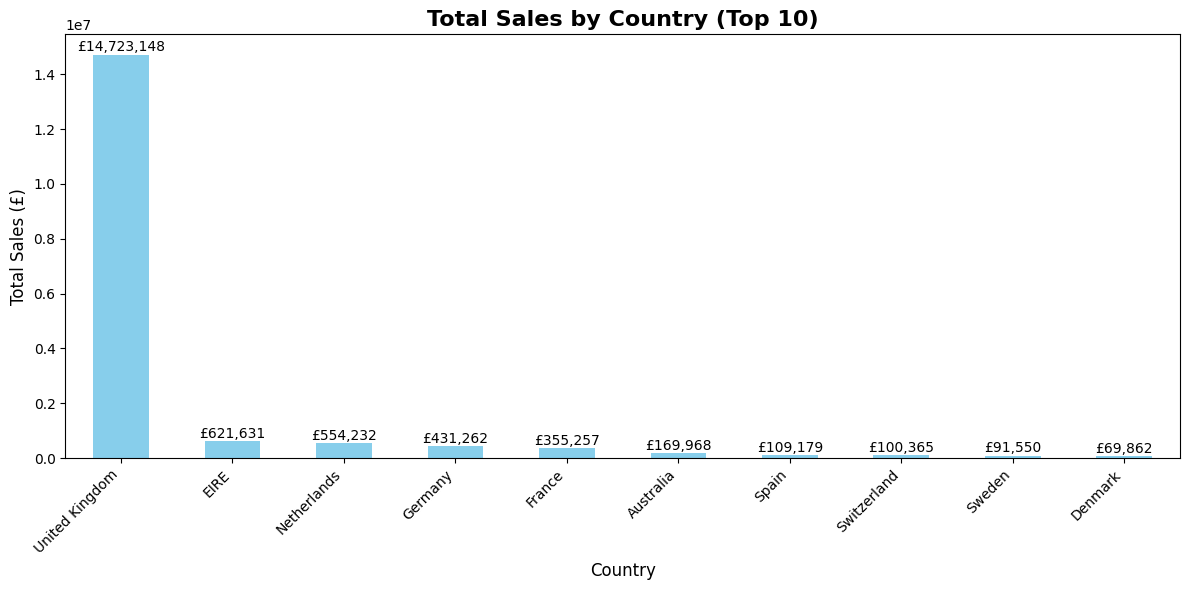

In [7]:
# Group by country and sum sales
sales_by_country = df.groupby('Country')['TotalSale'].sum().sort_values(ascending=False)
top_10_countries = sales_by_country.head(10)

# Create a bar chart
plt.figure(figsize=(12, 6))
top_10_countries.plot(kind='bar', color='skyblue')
plt.title('Total Sales by Country (Top 10)', fontsize=16, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Sales (£)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
# Add value labels on top of bars
for i, v in enumerate(top_10_countries.values):
    plt.text(i, v + 10000, f'£{v:,.0f}', ha='center', va='bottom')
plt.tight_layout() # Prevents labels from getting cut off
plt.show()

Customer Purchase Frequency Analysis:
Average number of orders per customer: 6.29
Median number of orders per customer: 3.00
Maximum number of orders by a single customer: 398

Number of one-time customers: 1623 (27.61%)
Total number of customers: 5878


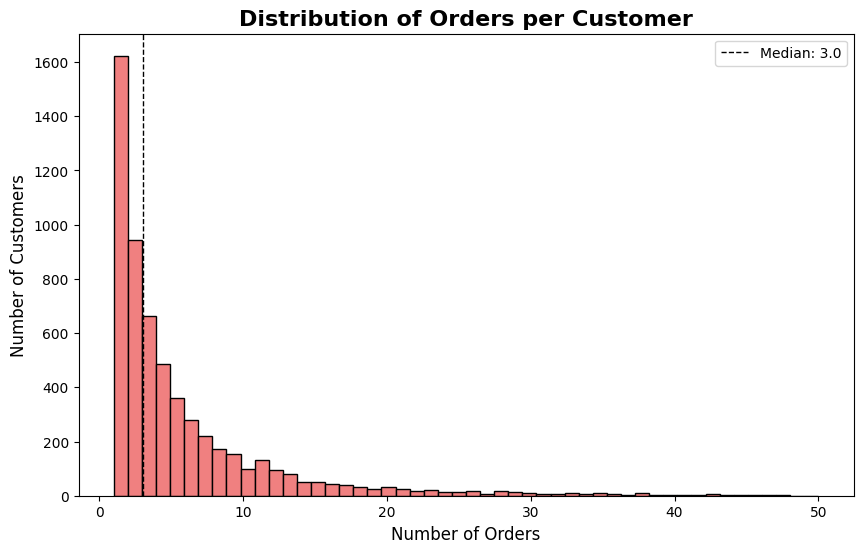

In [8]:
# Count unique invoices (orders) per customer
customer_activity = df.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False)

print("Customer Purchase Frequency Analysis:")
print("=====================================")
print(f"Average number of orders per customer: {customer_activity.mean():.2f}")
print(f"Median number of orders per customer: {customer_activity.median():.2f}")
print(f"Maximum number of orders by a single customer: {customer_activity.max()}")

# How many customers only bought once?
one_time_customers = (customer_activity == 1).sum()
total_customers = len(customer_activity)
churn_rate = (one_time_customers / total_customers) * 100

print(f"\nNumber of one-time customers: {one_time_customers} ({churn_rate:.2f}%)")
print(f"Total number of customers: {total_customers}")

# Visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(customer_activity, bins=50, color='lightcoral', edgecolor='black', range=(1, 50))
plt.title('Distribution of Orders per Customer', fontsize=16, fontweight='bold')
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.axvline(customer_activity.median(), color='k', linestyle='dashed', linewidth=1, label=f'Median: {customer_activity.median():.1f}')
plt.legend()
plt.show()

Setting up for Churn Prediction...
Last date in dataset: 2011-12-09
Percentage of churned customers: 50.85%
Training Model...

Model Accuracy: 1.0000

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00       578
     Churned       1.00      1.00      1.00       598

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176


FEATURE IMPORTANCE for predicting churn:
Recency      0.856629
Frequency    0.072819
Monetary     0.070552
dtype: float64


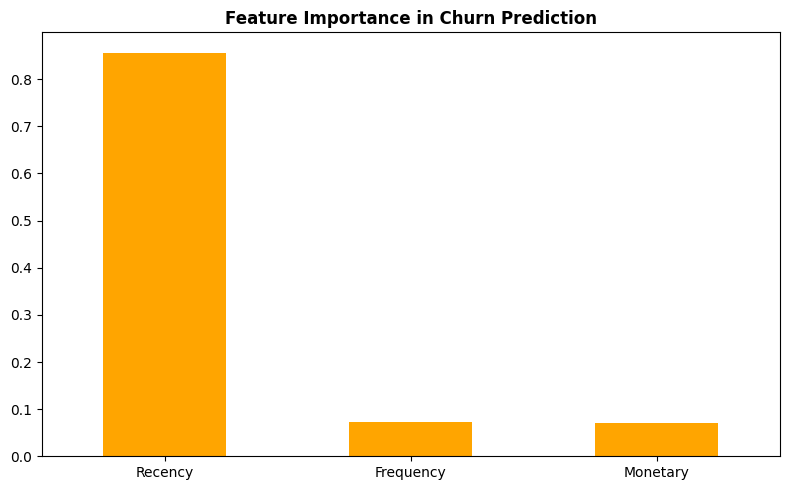

In [9]:
# 1. Define Churn
print("Setting up for Churn Prediction...")
last_date = df['InvoiceDate'].max()
print(f"Last date in dataset: {last_date.date()}")

# Create a summary of each customer's behavior (RFM Analysis)
customer_data = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique', # Frequency (F)
    'TotalSale': 'sum',     # Monetary Value (M)
    'InvoiceDate': 'max'    # Recency (R) - last purchase date
}).rename(columns={'InvoiceNo': 'Frequency', 'TotalSale': 'Monetary'})

# Define "Churn" as no purchase in the last 90 days of our data
snapshot_date = last_date + pd.Timedelta(days=1) # day after last order
customer_data['Recency'] = (snapshot_date - customer_data['InvoiceDate']).dt.days
customer_data['Churned'] = (customer_data['Recency'] > 90).astype(int) # 1 if Churned, 0 if not

print(f"Percentage of churned customers: {(customer_data['Churned'].mean() * 100):.2f}%")

# 2. Prepare Data for Model
X = customer_data[['Frequency', 'Monetary', 'Recency']] # Features
y = customer_data['Churned'] # Target variable

# 3. Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Train a simple model (Random Forest)
from sklearn.ensemble import RandomForestClassifier
print("Training Model...")
model = RandomForestClassifier(n_estimators=100, random_state=42) # Using 100 trees for better accuracy
model.fit(X_train, y_train)

# 5. Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Print a detailed report
print("\n" + "="*50)
print("CLASSIFICATION REPORT:")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Active', 'Churned']))

# Which features were most important?
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFEATURE IMPORTANCE for predicting churn:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(8, 5))
feature_importance.plot(kind='bar', color='orange')
plt.title('Feature Importance in Churn Prediction', fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()